# 04 - Classification with Neural Networks
In this section, we will assess the performance of various neural network models for classifying the offensiveness of a tweet. In particular, we will examine, in order of complexity:
- Multilayer perceptron with locally trained vectors
- Convolutional neural network with locally trained vectors
- Convolutional neural network with [pre-trained](https://nlp.stanford.edu/projects/glove/) vectors

Whereas Naive Bayes models learn and predict on some form of term frequency vectors, [neural networks](https://en.wikipedia.org/wiki/Artificial_neural_network) can use [word vector embeddings](https://www.tensorflow.org/tutorials/word2vec) in which each word is represented as a vector of pre-defined dimensionality. The key to the vector space model is that words with similar semantic meanings are also represented as similar vectors (as measured by some distance metric such as cosine similarity). There exist many methods to embedding the semantic meaning of a word, but they share in common the notion that a word's meaning can be defined by the totality of the contexts in which the word appears. In other words, a word's meaning is defined by its neighbors.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl

pd.options.display.max_colwidth = 400

%matplotlib inline

### Load data
Because word vector embeddings represent the semantic meaning of a word, the difference between various forms of a base word (ex: "am", "was", "be", "will", "is") is important to the model, and in fact previous embedding attempts during exploratory data analysis showed that lemmatized embeddings performed much worse in producing sensible similarities. Furthermore, because the dimensionality of the embedding is user-defined, the size of the vocabulary has less bearing on whether a model is at risk of overfitting. For this reason, we use un-lemmatized tweets for neural networks.

In [225]:
data_path = os.path.join('..','data','dataframe_clean')
with open(data_path, 'rb') as file_in:
    df_clean = pkl.load(file_in)
    
df_clean.head(3)

,text,rating,confidence
id,,,
853718217,warning : penny board will make -PRON- a faggot,1,0.6013
853718218,fuck dyke,2,0.7227
853718219,twitter_handle twitter_handle twitter_handle twitter_handle twitter_handle at least i do not look like jefree starr faggot,2,0.5229


In [3]:
from gensim.models import Word2Vec
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Flatten, Activation, Embedding, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


# Building an embedding matrix
Previously, when using term frequency models, a tweet was represented as a single vector. However, if instead, words are represented as vectors, and a tweet is a collection of words, then a tweet is represented not as a vector but as a matrix where the $i^{th}$ row is the vector embedding of the $i^{th}$ word in the tweet. This matrix representation of a tweet provides a similarity to the classification of images that is especially useful when working with convolutional neural networks later.

The conversion of a tweet into a matrix involves two elements: an index sequence vector and an embedding matrix. In this model, given a vocabulary of size $v$, each term of the vocabulary is assigned a unique index value from $0$ to $v-1$. A tweet's index sequence vector, then, is a vector in which its $i^{th}$ element is the index value of the $i^{th}$ word in the tweet.

An embedding matrix of size $v \times d$, where $d$ is a pre-specified dimensionality of the word vector embeddings, is a matrix in which the $n^{th}$ row is the $d$-dimensional vector embedding of the term corresponding to index value $n$. Thus, with an index sequence vector, we can select which rows of the embedding matrix to use to build a tweet's representational matrix.

Given our corpus of 13,000 tweets and vocabulary of 16,500, a 100-dimensional vector embedding is sufficient (prior tests showed that 100-dimensional embeddings outperformed 50 and 200-dimensional embeddings). We remove from the vocabulary all words that appear only once in the corpus since one set of neighbors does not seem to be enough to discern a word's meaning. Excluding all terms that appear in the corpus once leaves over 7,000 terms, much higher than the 261 terms used by Bernoulli Naive Bayes for classification.

Below, we train a Word2Vec model to learn the vector embeddings of the 7,000 terms.

In [318]:
np.random.seed(1701)
load_pretrained = False

# create 100-dimensional vector embeddings for words that appear in the corpus at least 2 times
embedding_dimension = 100

if load_pretrained:
    with open('../data/wordvec_model_local', 'rb') as file_in:
        model = pkl.load(file_in)
else:
    model = Word2Vec([tweet.split() for tweet in df_clean_old.text], min_count = 2, size = embedding_dimension,
                 window = 10, sg = 1)
    with open('../data/wordvec_model_local', 'wb') as file_out:
        pkl.dump(model, file_out)

max_vocab_size = len(model.wv.vocab)
print('word2vec vocabulary size:', max_vocab_size)

# tokenize each tweet in the corpus. this will be useful for embedding each tweet as an index sequence vector
tokenizer = Tokenizer(num_words = max_vocab_size)
tokenizer.fit_on_texts(df_clean.text)
print('tokenizer vocabulary size:', tokenizer.num_words)

word2vec vocabulary size: 6250
tokenizer vocabulary size: 6250


In [324]:
# create 100-dimensional vector embeddings for words that appear in the corpus at least 2 times
embedding_dimension = 100
model = Word2Vec([tweet.split() for tweet in df_clean_old.text], min_count = 2, size = embedding_dimension,
                 window = 10, sg = 1)
max_vocab_size = len(model.wv.vocab)
print('word2vec vocabulary size:', max_vocab_size)

# tokenize each tweet in the corpus. this will be useful for embedding each tweet as an index sequence vector
tokenizer = Tokenizer(num_words = max_vocab_size)
tokenizer.fit_on_texts(df_clean.text)
print('tokenizer vocabulary size:', tokenizer.num_words)

word2vec vocabulary size: 6250
tokenizer vocabulary size: 6250


A quick check of the most related terms to "trump" shows that the embeddings at least make sense semantically.

In [325]:
# check quality of word vector embedding
model.most_similar(['trump'])

[('muslim', 0.9571073055267334),
 ('donald', 0.9438065886497498),
 ('religion', 0.9416632652282715),
 ('anti', 0.936229944229126),
 ('isis', 0.9354050159454346),
 ('islam', 0.9333335757255554),
 ('war', 0.9265784025192261),
 ('term', 0.9259124398231506),
 ('clinton', 0.9255439043045044),
 ('race', 0.9246209859848022)]

Here, we construct an embedding matrix out of the trained vectors.

In [326]:
# create embedding matrix where each row corresponds to a vector for a word. the row index is determined by tokenizer.
embedding_matrix = np.zeros([max_vocab_size + 1, embedding_dimension])
for word, index in tokenizer.word_index.items():
    if word in model.wv.vocab and index < max_vocab_size:
        vector = model[word]
        embedding_matrix[index,:] = vector

print('number of terms without vector embeddings:', sum(embedding_matrix.sum(axis = 1) == 0))

number of terms without vector embeddings: 159


Because non-recurrent neural networks expect inputs of the same dimensions, we pad all index sequence vectors with zeros until they are the same length as the longest index sequence vector. The actual process of using an embedding matrix to convert an index sequence vector into a word matrix is a step within the Keras' neural network implementation itself.

In [327]:
# convert tweets to index sequence vectors
X = tokenizer.texts_to_sequences(df_clean.text)
max_sequence_length = np.array([len(sequence) for sequence in X]).max()
print('The tweet with the longest sequence has {} indices.'.format(max_sequence_length))

# pad index sequence vectors so they all have same length and X is rectangular
X = pad_sequences(X, maxlen = max_sequence_length, padding = 'post', truncating = 'post')
print('Matrix X has shape:', X.shape)

# create label matrix y
y = to_categorical(df_clean.rating)
print('Labels y has shape:', y.shape)

The tweet with the longest sequence has 35 indices.
Matrix X has shape: (13111, 35)
Labels y has shape: (13111, 3)


In [328]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3, stratify = df_clean.rating, random_state = 1)

# Multilayer perceptron
We begin with a "vanilla" neural network to set a baseline with which to measure the more sophisticated models against. Many different topologies were tested, but ultimately, the optimal network was a rather small one, with only two hidden layers consisting of 75 and 20 nodes. Even with such a small architecture, the network severely overfits the training data, producing training accuracies of around 0.9 against cross-validated accuracies of 0.75.

To combat this, a regularization technique called [dropout](http://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/) is applied in which for each learning pass, the network de-activates a randomly selected proportion of neurons so that they do not contribute information to downstream neurons during the feedforward phase and their associated weights are not updated during the backpropagation phase. The technique is elegant in that it has the effect of emulating an ensemble method where several smaller networks are trained and averaged together.

In [350]:
mlp = Sequential()
mlp.add(Embedding(embedding_matrix.shape[0],
                 embedding_matrix.shape[1],
                 weights = [embedding_matrix],
                 input_shape = (X.shape[1],)))
mlp.add(Flatten())
mlp.add(Dense(75, activation = 'relu'))
mlp.add(Dropout(0.75))
mlp.add(Dense(20, activation = 'relu'))
mlp.add(Dropout(0.75))
mlp.add(Dense(3, activation = 'softmax'))
mlp.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [351]:
early_stopping = EarlyStopping(patience = 2, monitor = 'val_acc')
history = mlp.fit(X_train, y_train, validation_split = 0.3, epochs = 30, callbacks = [early_stopping],
                  batch_size = 200, verbose = False)

Notably, it takes a rather high dropout rate of 0.75 to reasonably control the network's tendency to overfit, but the improvement in cross-validated accuracy is modest at best, increasing to 0.763. In fact, even a network with as small as a 30-to-10 node topology tends to overfit while producing cross-validated accuracies of 0.73. In much the same way the optimized Naive Bayes models only needed to consider a few hundred terms out of the entire vocabulary, the network may be focusing a small set of terms.

training accuracy: 0.799159270969
validation accuracy: 0.769426280117


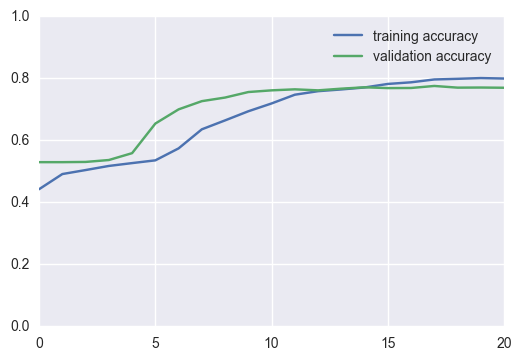

In [352]:
train_acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(train_acc, label = 'training accuracy')
plt.plot(val_acc, label = 'validation accuracy')
plt.legend(loc = 0)
plt.ylim(0,1)
print('training accuracy:', train_acc[-1])
print('validation accuracy:', val_acc[-1])

### Model evaluation

In [103]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

def proba_to_prediction(predict_probas):
    predictions = np.array([np.argmax(row) for row in predict_probas])
    return predictions

def evaluate(y, y_pred):
    print('Accuracy:', accuracy_score(y, y_pred))
    print('F1 weighted: ', f1_score(y, y_pred, average = 'weighted'))
    
    matrix = confusion_matrix(y, y_pred)
    matrix = matrix / matrix.sum().sum()
    print('Normalized confusion matrix:\n', matrix)
    
    y_values = pd.Series(y).value_counts()
    y_values = y_values / y_values.sum()
    print('Actual proportions:\n', np.array(y_values))
    
def flatten(y):
    y_cat = y.copy()
    y_cat[:,0] = 0
    y_cat[:,2] = y_cat[:,2] * 2
    y_cat = y_cat.sum(axis = 1)
    return y_cat

Unlike Naive Bayes models, neural networks can learn non-linear decision boundaries, theoretically resulting in more nuanced classifications, yet despite being a more complex model, the MLP actually performs worse than all the Naive Bayes models. In particular, the MLP does not classify a single tweet as hate speech. 

A potential reason for this is that the MLP is actually handicapped by the choice of tweet representation model. Recall that when tweets were represented as term frequency vectors for Naive Bayes classification, the models trained and predicted a tweet rating only on the basis of the presence or multiplicity of terms in the tweet. In other words, it did not matter where the term occurs in the tweet, only that it did occur some number of times. When using a matrix of vector embeddings to represent the tweet instead, the position in which terms occur within a tweet become part of the model, so for example, "apples and oranges" and "oranges and apples" are converted into different vectors.

This lack of translational invariance could mean that under this representational model, the MLP would require more samples of hate speech than what is currently available to learn how to identify it. Using image classification to illustrate this issue, imagine an MLP designed to distinguish circles from other shapes. If we only gave it as positive samples images with circles in the upper left hand corner, the model would be able to identify a circle located in any of the other corners. Similarly, if we provided the model as positive samples only four images of a circle each in a different corner, the model would likely not be able to identify a circle at all.

Now consider three hypothetical hate speech tweets where ------ represents an epithet:

1. ------ fuck you
2. ------ you fuck
3. fuck you ------

Using a term frequency model, the three tweets would be identical, so the classifier has essentially three training samples with which to learn that any permutation of "------", "fuck", and "you" should be considered hate speech. However, with a matrix embedding model, the same three tweets would convert to different matrices, like circles in different corners, and the classifier may not learn that any of them much less a new permutation should be considered hate speech.


In [104]:
predict_probas_mlp = mlp.predict(X_test)
y_test_pred_mlp = proba_to_prediction(predict_probas_mlp).reshape(-1)
y_test_flatten = flatten(y_test).reshape(-1)
evaluate(y_test_flatten, y_test_pred_mlp)

Accuracy: 0.754966887417
F1 weighted:  0.699040080471
Normalized confusion matrix:
 [[ 0.46943454  0.04737646  0.        ]
 [ 0.04482934  0.28553235  0.        ]
 [ 0.01706572  0.13576159  0.        ]]
Actual proportions:
 [ 0.516811    0.33036169  0.15282731]


//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Two-class performance evaluation

In [107]:
y_binary = (y_test_flatten == 1) | (y_test_flatten == 2)
y_pred_binary = (y_test_pred_mlp == 1) | (y_test_pred_mlp == 2)
evaluate(y_binary, y_pred_binary)

Accuracy: 0.890728476821
F1 weighted:  0.890651925847
Normalized confusion matrix:
 [[ 0.46943454  0.04737646]
 [ 0.06189506  0.42129394]]
Actual proportions:
 [ 0.516811  0.483189]


# Convolutional neural network

In [162]:
from keras.layers import Dense, Flatten, Activation, Embedding, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D

In [346]:
with open('../data/embedding_matrix_old', 'rb') as file_in:
    embedding_matrix = pkl.load(file_in)

cnn = Sequential()
cnn.add(Embedding(embedding_matrix.shape[0],
                 embedding_matrix.shape[1],
                 weights = [embedding_matrix],
                 input_shape = (X.shape[1],)))
#cnn.add(Flatten())
cnn.add(Conv1D(20, 5, padding = 'valid', strides = 1, activation = 'relu'))
cnn.add(Dropout(0.3))
cnn.add(GlobalMaxPooling1D())
#cnn.add(Conv1D(20, 3, padding = 'valid', strides = 1, activation = 'relu'))
#cnn.add(GlobalMaxPooling1D())
#cnn.add(Dense(20, activation = 'relu'))
cnn.add(Dropout(0.3))
#cnn.add(Dense(50, activation = 'relu'))
#cnn.add(Dropout(0.1))
#cnn.add(Dense(10, activation = 'relu'))
cnn.add(Dense(3, activation = 'softmax'))
cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [347]:
early_stopping = EarlyStopping(patience = 2, monitor = 'val_acc')
history = cnn.fit(X_train, y_train, validation_split = 0.3, epochs = 30, callbacks = [early_stopping],
                  batch_size = 200, verbose = False)

training accuracy: 0.834812390114
validation accuracy: 0.78322440862


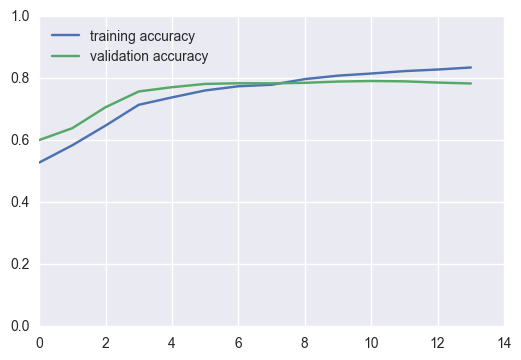

In [348]:
train_acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(train_acc, label = 'training accuracy')
plt.plot(val_acc, label = 'validation accuracy')
plt.legend(loc = 0)
plt.ylim(0,1)
print('training accuracy:', train_acc[-1])
print('validation accuracy:', val_acc[-1])

In [349]:
predict_probas_cnn = cnn.predict(X_test)
y_test_pred_cnn = proba_to_prediction(predict_probas_cnn).reshape(-1)
y_test_flatten = flatten(y_test).reshape(-1)
evaluate(y_test_flatten, y_test_pred_cnn)

Accuracy: 0.782155566853
F1 weighted:  0.755076644915
Normalized confusion matrix:
 [[  4.84494154e-01   3.17742755e-02   2.54194204e-04]
 [  3.91459075e-02   2.71479410e-01   1.98271479e-02]
 [  1.60142349e-02   1.10828673e-01   2.61820031e-02]]
Actual proportions:
 [ 0.51652262  0.33045247  0.15302491]


In [581]:
def tweet_rater(tweet):
    #tweet_tokens = [token.lemma_ for token in nlp(tweet)]
    #tweet = ' '.join(tweet_tokens)
    x_vect = tokenizer.texts_to_sequences([tweet])
    x_vect = pad_sequences(x_vect, maxlen = max_sequence_length)
    probas = mlp.predict(x_vect)[0]
    rating = np.argmax(probas)
    if rating == 0:
        print('I\'m {:2.4}% sure that\'s not offensive.'.format(probas[0]*100))
    elif rating == 1:
        print('I\'m {:2.4}% sure that\'s offensive.'.format(probas[1]*100))
    else:
        print('I\'m {:2.4}% sure that\'s hate speech.'.format(probas[2]*100))

In [582]:
tweet_rater('i hate you all')

I'm 48.62% sure that's offensive.


In [583]:
df = df.reindex(df_clean.index)